In [2]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from itertools import combinations
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import texthero as hero
import regex as re


from torchtext.vocab import FastText
from torchtext.vocab import GloVe

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext import data
from torchtext import datasets

from collections import Counter
from torchtext.vocab import vocab

import numpy as np
import random
import math

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\K1NG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\K1NG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\K1NG\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\K1NG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Check your version
# On Colab, you'll see ('1.10.2+cu102', '0.11.2')
print(torch.__version__, torchtext.__version__)
USE_CUDA = torch.cuda.is_available()
torch.cuda.is_available()

1.10.2+cu113 0.11.2


True

In [4]:
GLOVE = GloVe(name='6B', dim=100)
FASTTEXT = FastText('simple')


.vector_cache\glove.6B.zip: 862MB [02:40, 5.37MB/s]                               
100%|█████████▉| 399999/400000 [00:19<00:00, 20861.53it/s]
.vector_cache\wiki.simple.vec: 293MB [00:11, 25.3MB/s]                              
100%|██████████| 111051/111051 [00:11<00:00, 9296.08it/s]


In [7]:
GLOVE_EMBEDDING_PATH = '../input/glove840b300dtxt/glove.840B.300d.txt'


### Loading the data

In [65]:
train = pd.read_csv('./data/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test = pd.read_csv('./data/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv')

In [66]:
print(train["target"].isna().value_counts())
train["label"] = train["target"].apply(lambda x: 1 if x>=0.5 else 0)
print(test["toxicity"].isna().value_counts())
test["label"] = test["toxicity"].apply(lambda x: 1 if x>=0.5 else 0)

False    1804874
Name: target, dtype: int64
False    97320
Name: toxicity, dtype: int64


In [67]:
IDENTITY_COLUMNS = ['asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white']




In [68]:
train["identity"] = (train[IDENTITY_COLUMNS].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int)

C:\Users\K1NG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [69]:
train["identity"].value_counts()

0    1634570
1     170304
Name: identity, dtype: int64

<AxesSubplot:title={'center':'Distribution of identities'}>

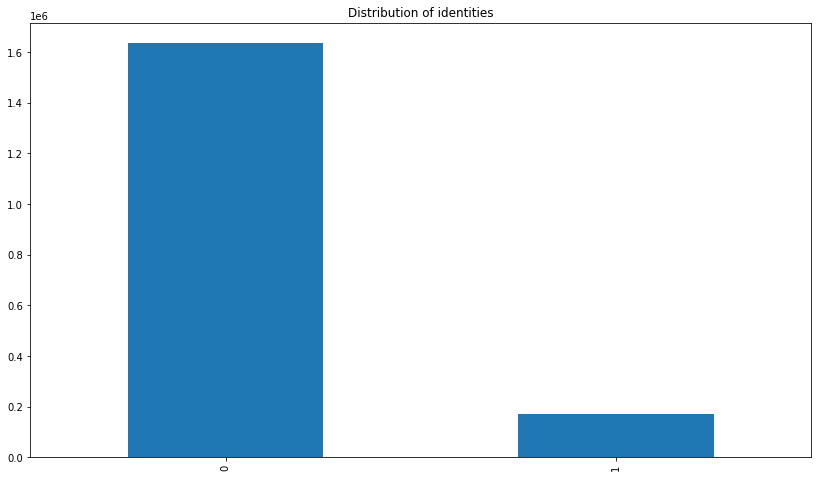

In [12]:
train["identity"].value_counts().plot(kind="bar", figsize=(14,8), title="Distribution of identities")

In [70]:
test["identity"] = (test[IDENTITY_COLUMNS].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int)

C:\Users\K1NG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [71]:
train["train_set"] = 1

In [72]:
test["train_set"] = 0

In [64]:
test

,id,comment_text,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,...,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,identity,train_set
0,7000000,Jeff Sessions is another one of Trump's Orwell...,2017-01-26 07:37:38.422417+00,13,NaN,164149,approved,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,7000001,I actually inspected the infrastructure on Gra...,2016-12-03 20:38:21.204649+00,54,655260.0,154341,approved,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,7000002,No it won't . That's just wishful thinking on ...,2017-05-05 18:07:58.560078+00,21,5219683.0,332005,approved,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,7000003,Instead of wringing our hands and nibbling the...,2017-02-09 14:46:30.189044+00,13,NaN,167110,approved,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,7000004,how many of you commenters have garbage piled ...,2016-10-15 01:18:40.521923+00,21,NaN,148484,approved,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97315,7097315,That's the thing...it's called a plan. Get in...,2017-10-10 22:55:35.959552+00,22,6121495.0,387369,approved,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
97316,7097316,"It's not quite the way you describe it, Mike. ...",2016-07-22 23:13:21.954981+00,6,397856.0,142051,approved,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
97317,7097317,What right have you to criticise? You have no ...,2017-11-05 09:32:53.455093+00,100,6271951.0,396093,approved,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
97318,7097318,My concern is that if China allies with the US...,2017-04-17 15:39:29.501250+00,54,NaN,327347,approved,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


### Now let us select relevant columns of train and test set and merge them together

In [73]:
df1 = train[["id", "comment_text", "identity", "train_set", "label"]]
df2 = test[["id", "comment_text", "identity", "train_set", "label"]]

data = df1.append(df2, ignore_index=True)
data

,id,comment_text,identity,train_set,label
0,59848,"This is so cool. It's like, 'would you want yo...",0,1,0
1,59849,Thank you!! This would make my life a lot less...,0,1,0
2,59852,This is such an urgent design problem; kudos t...,0,1,0
3,59855,Is this something I'll be able to install on m...,0,1,0
4,59856,haha you guys are a bunch of losers.,0,1,1
...,...,...,...,...,...
1902189,7097315,That's the thing...it's called a plan. Get in...,0,0,0
1902190,7097316,"It's not quite the way you describe it, Mike. ...",0,0,0
1902191,7097317,What right have you to criticise? You have no ...,0,0,0
1902192,7097318,My concern is that if China allies with the US...,0,0,0


### Text Preprocessing

#### 1. Creating target variables

False    1804874
Name: target, dtype: int64

<AxesSubplot:title={'center':'Distribution of identities'}>

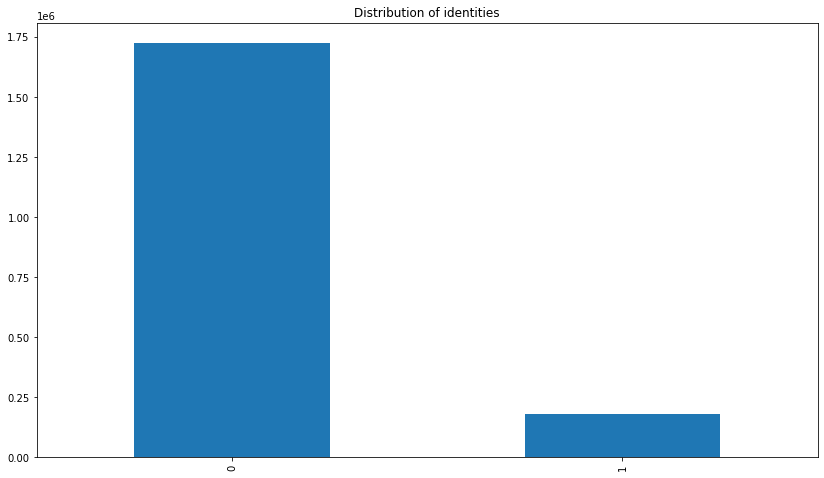

In [74]:
data["identity"].value_counts().plot(kind="bar", figsize=(14,8), title="Distribution of identities")

<AxesSubplot:title={'center':'Distribution of class labels'}>

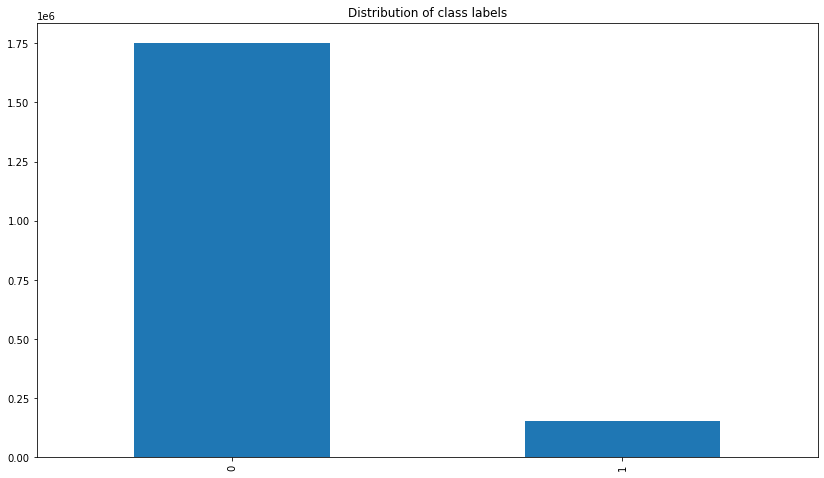

In [75]:
data["label"].value_counts().plot(kind="bar", figsize=(14,8), title="Distribution of class labels")

In [87]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)
# data[["comment_text", "label"]].head(100)
# sh*tty
# ur
# hahahahahahahahhha
# \nsheriff
# whaaaaaatttttt?
# waaaaay
# BwaaaaaaaaaHahahahahaha
# aaaaalmost
# bbbaaaaaa
# Whaaaaaat
# DISCUSSTING

# remove punctuation and replace with an empty single space
# lower level
# downsampling is also important 
# data[data["comment_text"].str.contains("aaaaa") == True][["comment_text", "label"]]

C:\Users\K1NG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [102]:
def preprocess(data):
    '''
    "Try with stop words and without stop words
    Try with and without lemmatization
    '''
    # punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    # for p in punct:
    #     data["text"] = data.replace(p, ' ')


    # data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    # return data
    # data["clean_text"] = data["comment_text"].apply(lambda x: x.replace(r'\n',  ' '))
    data["clean_text"] = data["comment_text"].apply(lambda x: re.sub(r'\n', " ", x))
    data["clean_text"] = data["clean_text"].replace(r'\\n',' ', regex=True)
    data["clean_text"] = data["clean_text"].replace('\n',' ', regex=True)
    # data["clean_text"] = data["comment_text"].apply(lambda x: x.replace('\n',  ' '))

    custom_pipeline = [
        # hero.preprocessing.remove_whitespace,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_stopwords]

    data['clean_text'] = hero.clean(data['comment_text'], custom_pipeline)
    data["clean_text"] = data["clean_text"].apply(lambda x: re.sub(r'[0-9]', "", x))
    # punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    data["clean_text"] = data["clean_text"].apply(lambda x: re.sub(r"/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`", "", x))
    data["clean_text"] = data["clean_text"].apply(lambda x: re.sub(r'""“”’', "", x))
    data["clean_text"] = data["clean_text"].apply(lambda x: re.sub(r'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&', "", x))

    return data

preprocess(data)
data


,id,comment_text,identity,train_set,label,clean_text
0,59848,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0,1,0,cool like would want mother read really great idea well done
1,59849,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0,1,0,thank would make life lot less anxiety inducing keep let anyone get way
2,59852,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0,1,0,urgent design problem kudos taking impressive
3,59855,Is this something I'll be able to install on my site? When will you be releasing it?,0,1,0,something able install site releasing
4,59856,haha you guys are a bunch of losers.,0,1,1,haha guys bunch losers
...,...,...,...,...,...,...
1902189,7097315,"That's the thing...it's called a plan. Get into a shelter so that you can take shower daily. Get job to start a savings. Save up (and not waste it on booze or drugs or pets or whatever) and have a plan to start renting. Then, while renting, have a goal to save up so you can buy. If not here, buy elsewhere. \nBy the way, the ones hustling isn't the ones over at Kakaako and Nimitz. Go drive by Nimitz, some have nicer cars than me! So don't tell me that's from dumpster diving. They obviously have ""wants"" overtaking their ""needs"".",0,0,0,thing called plan get shelter take shower daily get job start savings save waste booze drugs pets whatever plan start renting renting goal save buy buy elsewhere \n way ones hustling ones kakaako nimitz go drive nimitz nicer cars tell dumpster diving obviously wants overtaking needs
1902190,7097316,"It's not quite the way you describe it, Mike. The ""roads"" in our cities are actually public space, owned by us all. They are spaces for people. This has been the case since the beginning of cities. Automobiles are a relatively new appearance on urban streets, enjoying the paved streets that resulted because - wait for it - BICYCLISTS led the fight for better roads. Cars and trucks create infinitely more damage to our streets - our shared public space - than bicycles ever will, and they subsumed public space that was previously the domain of people on foot, bicycle or horse, creating a congested, dangerous mess in the process. So no, bicycles don't need to pay for maintenance.",0,0,0,quite way describe mike roads cities actually public space owned us spaces people case since beginning cities automobiles relatively new appearance urban streets enjoying paved streets resulted wait bicyclists led fight better roads cars trucks create infinitely damage streets shared public space bicycles ever subsumed public space previously domain people foot bicycle horse creating congested dangerous mess process bicycles need pay maintenance
1902191,7097317,What right have you to criticise? You have no automatic moral authority either.\n\nDoublethink!,0,0,0,right criticise automatic moral authority either \n\ndoublethink
1902192,7097318,"My concern is that if China allies with the US to stem the insanity of NK's nukes and ICBMs, Putin and Russia will step in to help NK. Xi knows he is better off being friends with Trump than with Kim. China does not want millions of North Korean refugees flooding across the border in case of war. Putin doesn't give a damn about either China or the US. For that matter, Iran could come to Nk's aid too.",0,0,0,concern china allies us stem insanity nk nukes icbms putin russia step help nk xi knows better friends trump kim china want millions north korean refugees flooding across border case war putin give damn either china us matter iran could come nk aid


In [103]:
# data.sort_values(by="label", ascending=False)

In [104]:
data["tokens"] = data["clean_text"].apply(lambda x: nltk.tokenize.word_tokenize(x))

In [105]:
def lemmatize_text(text):
    '''
    '''
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

data["tokens"] = data["tokens"].apply(lemmatize_text)
data

,id,comment_text,identity,train_set,label,clean_text,tokens
0,59848,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0,1,0,cool like would want mother read really great idea well done,"[cool, like, would, want, mother, read, really, great, idea, well, done]"
1,59849,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0,1,0,thank would make life lot less anxiety inducing keep let anyone get way,"[thank, would, make, life, lot, le, anxiety, inducing, keep, let, anyone, get, way]"
2,59852,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0,1,0,urgent design problem kudos taking impressive,"[urgent, design, problem, kudos, taking, impressive]"
3,59855,Is this something I'll be able to install on my site? When will you be releasing it?,0,1,0,something able install site releasing,"[something, able, install, site, releasing]"
4,59856,haha you guys are a bunch of losers.,0,1,1,haha guys bunch losers,"[haha, guy, bunch, loser]"
...,...,...,...,...,...,...,...
1902189,7097315,"That's the thing...it's called a plan. Get into a shelter so that you can take shower daily. Get job to start a savings. Save up (and not waste it on booze or drugs or pets or whatever) and have a plan to start renting. Then, while renting, have a goal to save up so you can buy. If not here, buy elsewhere. \nBy the way, the ones hustling isn't the ones over at Kakaako and Nimitz. Go drive by Nimitz, some have nicer cars than me! So don't tell me that's from dumpster diving. They obviously have ""wants"" overtaking their ""needs"".",0,0,0,thing called plan get shelter take shower daily get job start savings save waste booze drugs pets whatever plan start renting renting goal save buy buy elsewhere \n way ones hustling ones kakaako nimitz go drive nimitz nicer cars tell dumpster diving obviously wants overtaking needs,"[thing, called, plan, get, shelter, take, shower, daily, get, job, start, saving, save, waste, booze, drug, pet, whatever, plan, start, renting, renting, goal, save, buy, buy, elsewhere, way, one, hustling, one, kakaako, nimitz, go, drive, nimitz, nicer, car, tell, dumpster, diving, obviously, want, overtaking, need]"
1902190,7097316,"It's not quite the way you describe it, Mike. The ""roads"" in our cities are actually public space, owned by us all. They are spaces for people. This has been the case since the beginning of cities. Automobiles are a relatively new appearance on urban streets, enjoying the paved streets that resulted because - wait for it - BICYCLISTS led the fight for better roads. Cars and trucks create infinitely more damage to our streets - our shared public space - than bicycles ever will, and they subsumed public space that was previously the domain of people on foot, bicycle or horse, creating a congested, dangerous mess in the process. So no, bicycles don't need to pay for maintenance.",0,0,0,quite way describe mike roads cities actually public space owned us spaces people case since beginning cities automobiles relatively new appearance urban streets enjoying paved streets resulted wait bicyclists led fight better roads cars trucks create infinitely damage streets shared public space bicycles ever subsumed public space previously domain people foot bicycle horse creating congested dangerous mess process bicycles need pay maintenance,"[quite, way, describe, mike, road, city, actually, public, space, owned, u, space, people, case, since, beginning, city, automobile, relatively, new, appearance, urban, street, enjoying, paved, street, resulted, wait, bicyclist, led, fight, better, road, car, truck, create, infinitely, damage, street, shared, public, space, bicycle, ever, subsumed, public, space, previously, domain, people, foot, bicycle, horse, creating, congested, dangerous, mess, process, bicycle, need, pay, maintenance]"
1902191,7097317,What right have you to criticise? You

In [106]:


#stopwords = stopwords.words('english')
# stopwords = set(nltk.corpus.stopwords.words('english'))

# Remove single-character tokens (mostly punctuation)
data["tokens"] = data["tokens"].apply(lambda x: [word for word in x if len(word) > 1])

# # Remove numbers
# #words = [word for word in words if not word.isnumeric()]

# # Remove punctuation
# # words = [word for word in words if word.isalpha()]

# # Lowercase all words (default_stopwords are lowercase too)
# words = [word.lower() for word in words]

# # Remove stopwords
# words = [word for word in words if word not in stopwords]

# fdist = nltk.FreqDist(words)

# print(fdist)

# #fdist.items() - will give all words
# fdist.most_common(500)

In [37]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [34]:
data["clean_text"] = data["tokens"].str.join(" ")
data

,id,comment_text,identity,train_set,label,clean_text,tokens
0,59848,"This is so cool. It's like, 'would you want yo...",0,1,0,cool like would want mother read really great ...,"[cool, like, would, want, mother, read, really..."
1,59849,Thank you!! This would make my life a lot less...,0,1,0,thank would make life lot le anxiety inducing ...,"[thank, would, make, life, lot, le, anxiety, i..."
2,59852,This is such an urgent design problem; kudos t...,0,1,0,urgent design problem kudos taking impressive,"[urgent, design, problem, kudos, taking, impre..."
3,59855,Is this something I'll be able to install on m...,0,1,0,something able install site releasing,"[something, able, install, site, releasing]"
4,59856,haha you guys are a bunch of losers.,0,1,1,haha guy bunch loser,"[haha, guy, bunch, loser]"
...,...,...,...,...,...,...,...
1902189,7097315,That's the thing...it's called a plan. Get in...,0,0,0,thing called plan get shelter take shower dail...,"[thing, called, plan, get, shelter, take, show..."
1902190,7097316,"It's not quite the way you describe it, Mike. ...",0,0,0,quite way describe mike road city actually pub...,"[quite, way, describe, mike, road, city, actua..."
1902191,7097317,What right have you to criticise? You have no ...,0,0,0,right criticise automatic moral authority eith...,"[right, criticise, automatic, moral, authority..."
1902192,7097318,My concern is that if China allies with the US...,0,0,0,concern china ally stem insanity nk nuke icbm ...,"[concern, china, ally, stem, insanity, nk, nuk..."


### Preparing wordcloud for toxic messages

In [35]:
toxic_data= data[data.label==1]

In [38]:
toxic_text_list = toxic_data['clean_text'].tolist()

tfidfvectorizer = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1,1), max_features=100)
tfidfvectorizer_matrix = tfidfvectorizer.fit_transform(toxic_text_list)

tfidfvectorizer_matrix_df = pd.DataFrame(tfidfvectorizer_matrix.toarray(), columns=tfidfvectorizer.get_feature_names())

In [39]:
feature_names = tfidfvectorizer.get_feature_names()
dense = tfidfvectorizer_matrix.todense()
lst1 = dense.tolist()
words_df = pd.DataFrame(lst1, columns=feature_names)
words_df

,actually,america,american,bad,believe,better,black,canada,canadian,care,...,vote,want,way,white,woman,word,work,world,year,yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.254256,0.000000,0.000000,0.000000,0.0,0.301483,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
152001,0.0,0.0,0.0,0.0,0.0,0.0,0.644485,0.0,0.000000,0.000000,...,0.0,0.000000,0.287546,0.562998,0.000000,0.0,0.000000,0.0,0.0,0.0
152002,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.328448,0.0,0.000000,0.0,0.0,0.0
152003,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.515947,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0


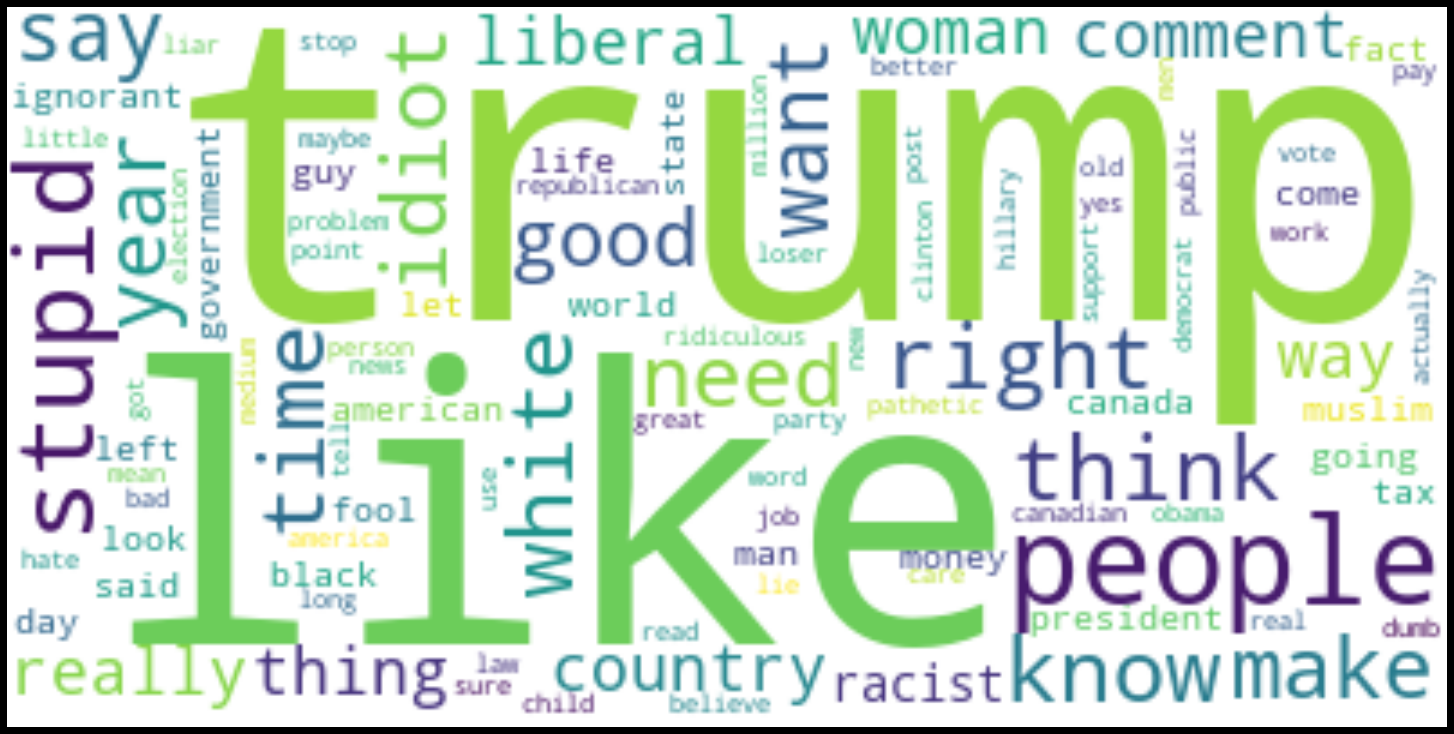

In [40]:
cloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(words_df.T.sum(axis=1))

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(cloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [41]:
nontoxic_data = data[data.label==0]
nontoxic_text_list = nontoxic_data['clean_text'].tolist()

tfidfvectorizer = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1,1), max_features=100)
tfidfvectorizer_matrix = tfidfvectorizer.fit_transform(nontoxic_text_list)

tfidfvectorizer_matrix_df = pd.DataFrame(tfidfvectorizer_matrix.toarray(), columns=tfidfvectorizer.get_feature_names())
feature_names = tfidfvectorizer.get_feature_names()
dense = tfidfvectorizer_matrix.todense()
lst1 = dense.tolist()
words_df = pd.DataFrame(lst1, columns=feature_names)
words_df

,actually,agree,alaska,american,article,bad,believe,best,better,big,...,use,vote,want,way,woman,work,world,wrong,year,yes
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.417883,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.363062,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750184,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.437398,0.430475,0.0,0.0,0.0,0.0,0.0,0.0
1750185,0.214307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.206595,0.0,...,0.0,0.0,0.000000,0.179720,0.0,0.0,0.0,0.0,0.0,0.0
1750186,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1750187,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.360220,0.0,...,0.0,0.0,0.318399,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


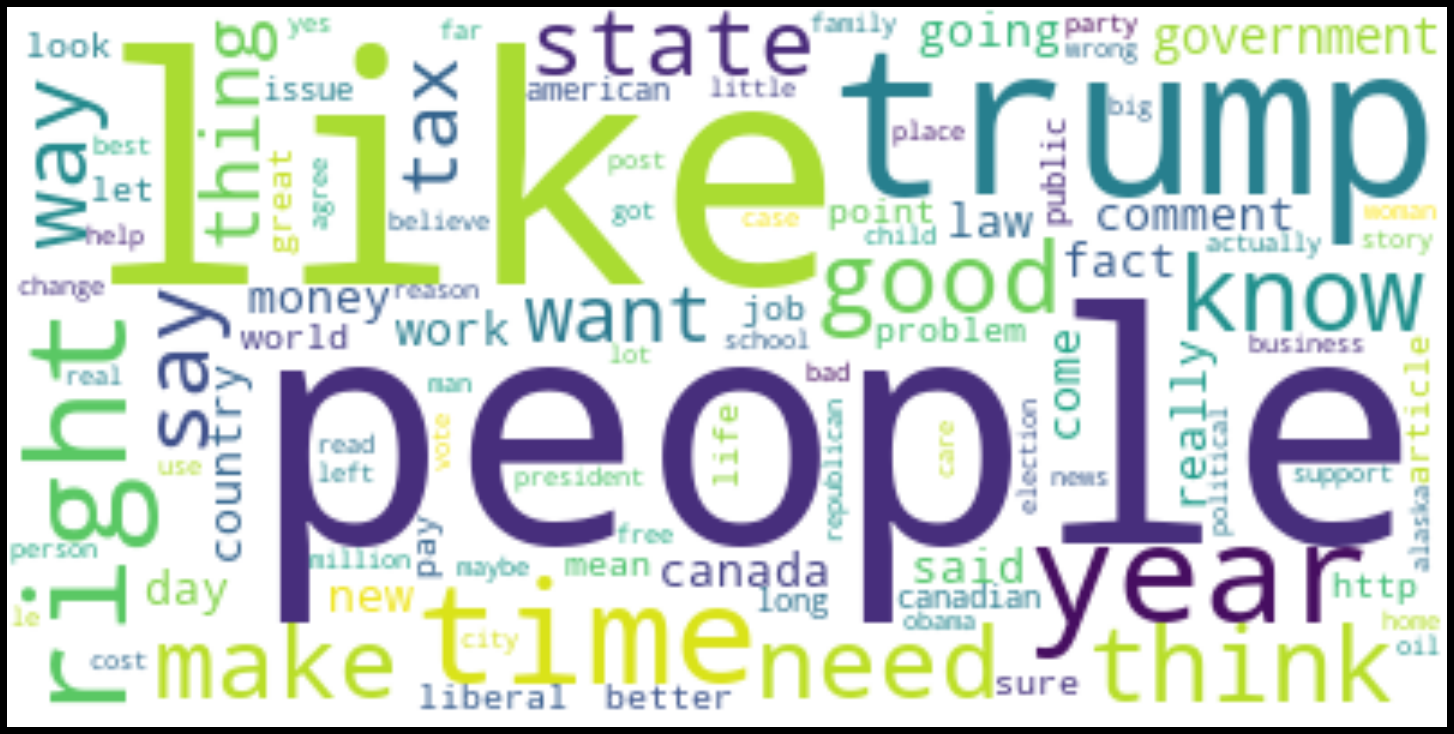

In [42]:
cloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(words_df.T.sum(axis=1))

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(cloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [43]:
from sklearn.model_selection import train_test_split, cross_val_score

train = data[data.train_set==1]
test = data[data.train_set==0]

X_train = train[["clean_text"]]
Y_train = train[["label"]]
X_test = test[["clean_text"]]
Y_test= test[["label"]]

#Overall
sample_weight = np.ones((len(X_train),))

#Subgroup: Add all the values of the identities along rows
sample_weight += (train["identity"].fillna(0))

#Background Positive, Subgroup Negative - Add all values of targets*~identity
sample_weight += train['label'] * (~train["identity"].astype(bool)).astype(int)

#Background Positive, Subgroup Negative -  Add all values ~targets*identity
sample_weight += (~train["label"].astype(bool)).astype(int) * train["identity"]

sample_weight /= sample_weight.mean()


In [ ]:
sample_weight

0          0.807951
1          0.807951
2          0.807951
3          0.807951
4          1.615902
             ...   
1804869    0.807951
1804870    0.807951
1804871    0.807951
1804872    1.615902
1804873    0.807951
Name: identity, Length: 1804874, dtype: float64

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train["clean_text"])
X_test = vectorizer.fit_transform(X_test["clean_text"])




# nb_clf = Pipeline([("vect", CountVectorizer()),
#                     ("tfidf", TfidfTransformer()),
#                     ("clf", MultinomialNB()),
#                 ])

# nb_clf.fit(X_train, Y_train)



In [47]:
X_train.shape

(1804874, 269337)

In [48]:
nb_clf1 = MultinomialNB()
nb_clf1.fit(X_train, Y_train)

F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MultinomialNB()

In [49]:
nb_cv_recall = cross_val_score(nb_clf1, X_train, Y_train, cv=5, scoring='recall')
print(nb_cv_recall)
print(nb_cv_recall.mean())

F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\

[0.53808847 0.52551356 0.50098729 0.5526726  0.54558997]
0.5325703785635323


In [50]:
nb_cv_roc = cross_val_score(nb_clf1, X_train, Y_train, cv=5, scoring='roc_auc')
print(nb_cv_roc)
print(nb_cv_roc.mean())

F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\

[0.84789643 0.84382258 0.83980687 0.85184467 0.85155918]
0.8469859459885175


In [51]:
nb_cv_precision = cross_val_score(nb_clf1, X_train, Y_train, cv=5, scoring='precision')
print(nb_cv_precision)
print(nb_cv_precision.mean())


F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\

[0.44443491 0.43358962 0.456589   0.41649915 0.4303123 ]
0.4362849963230017


In [52]:
nb_clf2 = MultinomialNB()
nb_clf2.fit(X_train, Y_train, sample_weight=sample_weight)

F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MultinomialNB()

In [53]:
nb_cv_recall = cross_val_score(nb_clf2, X_train, Y_train, cv=5, scoring='recall', fit_params={'sample_weight': sample_weight.to_list()})
print(nb_cv_recall)
print(nb_cv_recall.mean())

F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\

[0.63626286 0.61475041 0.59618249 0.64675928 0.62956419]
0.6247038456659381


In [54]:
nb_cv_roc = cross_val_score(nb_clf2, X_train, Y_train, cv=5, scoring='roc_auc', fit_params={'sample_weight': sample_weight.to_list()})
print(nb_cv_roc)
print(nb_cv_roc.mean())

F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\

[0.8546475  0.84778144 0.842932   0.85384298 0.85082583]
0.8500059465568798


In [55]:
nb_cv_precision = cross_val_score(nb_clf2, X_train, Y_train, cv=5, scoring='precision', fit_params={'sample_weight': sample_weight.to_list()})
print(nb_cv_precision)
print(nb_cv_precision.mean())

F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\Python37\lib\

[0.38975893 0.38442042 0.39741369 0.36978352 0.3798307 ]
0.38424145424854317


In [57]:
import gensim
from gensim.models import FastText

In [59]:
model = FastText(size=10, window=3, min_count=1)

In [89]:
def get_embedding(word):
    try:
        embedding=model[word]
    except:
        embedding=np.zeros((10,))
    return embedding

In [90]:
from sklearn.model_selection import train_test_split, cross_val_score

train = data[data.train_set==1]
test = data[data.train_set==0]

X_train = train[["tokens"]]
Y_train = train[["label"]]
X_test = test[["tokens"]]
Y_test= test[["label"]]

#Overall
sample_weight = np.ones((len(X_train),))

#Subgroup: Add all the values of the identities along rows
sample_weight += (train["identity"].fillna(0))

#Background Positive, Subgroup Negative - Add all values of targets*~identity
sample_weight += train['label'] * (~train["identity"].astype(bool)).astype(int)

#Background Positive, Subgroup Negative -  Add all values ~targets*identity
sample_weight += (~train["label"].astype(bool)).astype(int) * train["identity"]

sample_weight /= sample_weight.mean()


In [67]:
X_train["tokens"]

0          [cool, like, would, want, mother, read, really...
1          [thank, would, make, life, lot, le, anxiety, i...
2          [urgent, design, problem, kudos, taking, impre...
3                [something, able, install, site, releasing]
4                                  [haha, guy, bunch, loser]
                                 ...                        
1804869    [maybe, tax, thing, would, collected, product,...
1804870    [call, people, still, think, divine, role, cre...
1804871             [thank, right, wrong, following, advice]
1804872    [anyone, quoted, following, exchange, even, ap...
1804873    [student, defined, ebd, legally, disabled, eli...
Name: tokens, Length: 1804874, dtype: object

In [91]:
X_train_embeddings=[np.mean(np.array(list(map(get_embedding,tok_sent))),axis=0) for tok_sent in X_train["tokens"]]

C:\Users\K1NG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
F:\Python37\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
F:\Python37\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [127]:
# np.concatenate(X_train_embeddings, axis=0)

count = 0
for i, embedding in enumerate(X_train_embeddings):
    if np.isnan(embedding).all():
        X_train_embeddings[i] = np.zeros(10, dtype=float)


In [139]:
X_train_embeddings = np.vstack(X_train_embeddings)

array([[-9.11366940e-03, -3.87669960e-03, -2.76596262e-03, ...,
        -8.27556010e-03, -1.17173968e-02, -1.03797030e-03],
       [-6.93383021e-03,  7.86592209e-05, -5.09960204e-03, ...,
        -8.31820630e-03, -1.20680165e-02,  6.28231000e-03],
       [-2.48843688e-03,  2.80530471e-03,  7.78274424e-03, ...,
        -3.21171619e-03, -2.12058332e-03, -1.01925815e-02],
       ...,
       [ 7.84513913e-03,  7.71010946e-03,  6.91522658e-03, ...,
         7.12495297e-04,  1.37557252e-03,  2.59799976e-03],
       [ 4.93620941e-03, -3.83321336e-03, -8.16482410e-04, ...,
         3.89433629e-03,  6.53089490e-03,  1.85107626e-03],
       [ 1.06227025e-03, -3.09459493e-03,  2.25854386e-03, ...,
         2.63235974e-03, -1.58843759e-03, -4.31396579e-03]])

In [144]:
np.array(Y_train[["label"]]).reshape(1,-1).shape

(1, 1804874)

array([-6.9338302e-03,  7.8659221e-05, -5.0996020e-03, -2.7118207e-04,
       -2.2145656e-03,  5.8074901e-03, -7.2069252e-03, -8.3182063e-03,
       -1.2068016e-02,  6.2823100e-03], dtype=float32)

In [70]:
X_test_embeddings=[np.mean(np.array(list(map(get_embedding,tok_sent))),axis=0) for tok_sent in X_test["tokens"]]

C:\Users\K1NG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [146]:
# nb_clf3= MultinomialNB()
# nb_clf3.fit(X_train_embeddings, Y_train)

from sklearn.svm import SVC

clf=SVC(kernel='linear',C=3)
clf.fit(X_train_embeddings,Y_train)

F:\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVC(C=3, kernel='linear')